# A. Loading the required libraries 
- importing standard python libraries 
- importing self written utils functions 
- declaring paths for finding data and saving text and images 

In [121]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline


#Libraries to make/construct the pdf for the final overview
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

# System libraries
import warnings
import sys
import os
import inspect
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import utils library with custom functions
# Annotation: If there is a change in the utils function collect this window has to be executed twice 
# In order to get the utils functions loaded to the kernel to make the updated versions available for the notebook 
from utils_finance import *
import utils_finance
import importlib
importlib.reload(utils_finance)

# This library is for an offline translater which is required for the pretrained classifier model
# The model was trained for english language but the script is made for german financial data 
from translate import Translator

# This downloads a pretrained large language machine learning model from hugging face library 
# The download process will be visible below 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Empty text_output list for filling during the script 
text_outputs = []

In [2]:
# Path to the neighboring 'plots' folder in the local repository
plots_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'plots'))
print(plots_path)


# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
print(data_path)

# Path to the neighboring 'reports' folder in the local repository where the conclusive report will be saved as a pdf 
report_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports'))
print(report_path)


/Users/tillo/Repositoriums/FinanceGrouper/plots
/Users/tillo/Repositoriums/FinanceGrouper/data
/Users/tillo/Repositoriums/FinanceGrouper/reports


# B. Data management
+ finding the data 
+ loading all available years  
+ concatenate all years of the data
+ saving the all years df  

In [3]:
# Retrieving data

# CSV files from DKB have a cryptic header; skip the first rows to make it readable
headerSize = 4

# List to store each DataFrame for later concatenation
dataframes = []

# Iterate through all files in the Data directory
for filename in os.listdir(data_path):
    # Skip "Data_All_Years.csv" if it already exists
    if filename == "Data_All_Years.csv":
        continue
    # Skip the training data for the ML model
    if filename == "Training_Data.csv":
        continue
    
    # Check if the file is a .csv file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(data_path, filename)

        # Extract the last 4 digits of the filename (assuming they represent the year)
        last_four_digits = filename[-8:-4]
        
        # Make the year variable
        year = int(last_four_digits)

        # Read the .csv file into a DataFrame
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path, sep=',', skiprows=headerSize, header=0, encoding='utf-8-sig')

        # Save the DataFrame under a dynamic name
        globals()[f'df_{last_four_digits}'] = df

        # Append the DataFrame to the list for concatenation
        dataframes.append(df)

        # Display the shape and column names of the DataFrame
        print('Shape:', df.shape)
        print('Column names:', df.columns)

# Concatenate all data to a single DataFrame
df_all_years = pd.concat(dataframes, ignore_index=True)

# Save the concatenated DataFrame to "Data_All_Years.csv"
output_path = os.path.join(data_path, "Data_All_Years.csv")
df_all_years.to_csv(output_path, index=False, sep=';')
print(f"Concatenated DataFrame saved to: {output_path}")


df = df_all_years

Reading file: /Users/tillo/Repositoriums/FinanceGrouper/data/DKB_Transactions_2022.csv
Shape: (70, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')
Concatenated DataFrame saved to: /Users/tillo/Repositoriums/FinanceGrouper/data/Data_All_Years.csv


In [4]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 70 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status                 Zahlungspflichtige*r  \
0      30.12.22     01.01.23  Gebucht                               DKB AG   
1      30.12.22     30.12.22  Gebucht                     Tillmann Stralka   
2      29.12.22     29.12.22  Gebucht                               ISSUER   
3      29.12.22     29.12.22  Gebucht   Hauptkasse des Freistaates Sachsen   
4      28.12.22     28.12.22  Gebucht  Helga Jakob-Stralka Norbert Stralka   

                            Zahlungsempfänger*in  \
0                                         DKB AG   
1  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
2                              PAYPAL .SPORTMORE   
3                               STRALKA TILLMANN   
4                               Tillmann Stralka   

                                    Verwendungszweck Umsatztyp  \
0  Abrechnung 30.12.2022 siehe Anlage Abrechnung .

# C. First cleaning of data set
+ deleting empty rows and columns 
+ fixing Euro ',' and '.' problem in numbers 
+ changing type of columns to numerical (floats) and types (object)
+ filter all entrances which have very long empty entrys and make them to only one ' '

In [5]:
### Deleting empty columns and rows for each df before saving it in a global variable 
# Identify columns that contain only NaN values
nan_columns = df.columns[df.isna().all()].tolist()    
# Drop the columns with only NaN values
df.drop(columns=nan_columns, inplace=True)
# Delete all rows that are completely empty (i.e., contain only NaN values)
empty_rows = df[df.isna().all(axis=1)].index
df.drop(index=empty_rows, inplace=True)

Set type of data of the columns 

In [6]:
# Fix US / EU decimal-point/comma
df['Betrag (€)'] = df['Betrag (€)'].str.replace('.','')
df['Betrag (€)'] = df['Betrag (€)'].str.replace(',','.')


In [7]:

# All columns will be set accordingly as dtype to what sort of stuff they contain 
df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], format='%d.%m.%y', errors='coerce')
df['Wertstellung'] = pd.to_datetime(df['Wertstellung'], format='%d.%m.%y', errors='coerce')
df['Status'] = df['Status'].astype('category')

# Make sure euro is set to float
df['Betrag (€)'] = df['Betrag (€)'].astype(float)

# List of columns which should be set and transformed to strings 
string_columns = [
    'Zahlungspflichtige*r',
    'Zahlungsempfänger*in',
    'Verwendungszweck',
    'IBAN',
    'Gläubiger-ID',
    'Mandatsreferenz',
    'Kundenreferenz'
]

for col in string_columns:
    # Zwingend sicherstellen, dass alle Werte entweder str oder pd.NA sind
    df[col] = df[col].apply(lambda x: x if isinstance(x, str) else pd.NA)
    # Konvertiere die Spalte zum Typ 'string'
    df[col] = df[col].astype('string')

#Check if it worked 
inspect_data(df)


🚀 Basic Data Overview
🗂 Shape of the DataFrame: 70 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status                 Zahlungspflichtige*r  \
0    2022-12-30   2023-01-01  Gebucht                               DKB AG   
1    2022-12-30   2022-12-30  Gebucht                     Tillmann Stralka   
2    2022-12-29   2022-12-29  Gebucht                               ISSUER   
3    2022-12-29   2022-12-29  Gebucht   Hauptkasse des Freistaates Sachsen   
4    2022-12-28   2022-12-28  Gebucht  Helga Jakob-Stralka Norbert Stralka   

                            Zahlungsempfänger*in  \
0                                         DKB AG   
1  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
2                              PAYPAL .SPORTMORE   
3                               STRALKA TILLMANN   
4                               Tillmann Stralka   

                                    Verwendungszweck Umsatztyp  \
0  Abrechnung 30.12.2022 siehe Anlage Abrechnung .

In [8]:
# Function to replace multiple spaces and new lines with a single space
df = reduce_multiple_spaces_and_newlines(df)

# D. Categorizing 
+ translation of the "verwendungszweck" column into english due to pre trained model 
+ categorizing of the incomes and expanses 
+ making separate category column 
+ shorting strings in df which are too long (informations are not needed anymore)

## D. 1 Translate

In [9]:
# This code translates the "Verwendungszweck" column into English for different descriptions 
# of the account transactions. 
# This is necessary because the pre-trained financial organizer operates in English.
# Using a German-to-English translator bridges this gap. 
# If the account transactions are already recorded in English, this function becomes redundant 
# and can be commented out.

# Create a translator from German to English
translator = Translator(from_lang="de", to_lang="en")

# Translation function for each row
def translate_text(text):
    try:
        # Attempt to translate the text
        return translator.translate(text)
    except Exception as e:
        # Handle any errors during translation
        return f"Error: {e}"

# Add a new column with the translated descriptions
df["Description_English"] = df["Verwendungszweck"].apply(translate_text)

# Print the translated column for verification
print(df["Description_English"])


0     QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY...
1        304-4204665-0990765 Amazon.de J1NULHQI5B3X4ZZU
2                               VISA DEBIT CARD REVENUE
3                                      REFERENCES 12.22
4            Christmas train travel subsidy, goose food
                            ...                        
65                              VISA DEBIT CARD REVENUE
66                                         G-10495-UZ-2
67                              VISA DEBIT CARD REVENUE
68                              VISA DEBIT CARD REVENUE
69                                      Parachute Money
Name: Description_English, Length: 70, dtype: object


## D. 2 Define categories & load model

In [83]:
# Load FinBERT-tone model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Define categories and corresponding keywords
categories = {
"Housing": [
    "rent", "miete", "monthly rent", "rental payment", "apartment rent", "flat rent", 
    "mortgage", "property taxes", "real estate tax", "home maintenance", "homeowners insurance", 
    "hoa fees", "house insurance", "apartment insurance", "property management", "landlord", 
    "vermieter", "tenant", "mieter", "rental contract", "lease", "lease agreement", 
    "rental deposit", "security deposit", "property maintenance", "repair costs", "apartment repair", 
    "utility costs", "Nebenkosten", "heating cost", "heating bill", "water bill", "electricity bill", 
    "internet bill", "trash collection fee", "building maintenance fee", "common area maintenance", 
    "garbage disposal", "parking fees", "garage rent", "storage unit rent", "property rental", 
    "vacation rental", "rental property", "property rental fee", "apartment complex", "real estate", 
    "real estate agent", "property buying", "house buying", "property selling", "house selling", 
    "real estate tax", "mortgage interest", "down payment", "home equity loan", "home loan", 
    "mortgage loan", "refinancing", "home appraisal", "moving costs", "moving truck", "moving company", 
    "storage fees", "rental property tax", "rent increase", "rent reduction", "rental income"
],
"Transportation": [
    "car payment", "gas", "public transit", "ridesharing", "parking", "tolls",
    "vehicle maintenance", "fuel", "auto repair", "commuting", "bike rental",
    "FERNVERKEHR", "flixbus", "PAYPAL .DBVERTR", "DB", "Flight", "Airport", 
    "Travel", "Reise", "taxi", "ride sharing", "Uber", "Lyft", "BlaBlaCar", "carpooling", 
    "bus", "train", "subway", "metro", "tram", "bike", "e-scooter", "e-bike", "train ticket",
    "flight ticket", "plane ticket", "airline", "lufthansa", "ryanair", "easyjet", "airfrance", 
    "kLM", "turkish airlines", "british airways", "emirates", "qatar airways", "saa", 
    "condor", "australian airlines", "jetstar", "wizz air", "air berlin", "airport shuttle", 
    "airport transfer", "rental car", "car hire", "travel insurance", "holiday travel", 
    "turbulence", "seat reservation", "boarding pass", "baggage fee", "excess baggage", 
    "flight change fee", "train station", "bus station", "taxi fare", "ride fee", 
    "petrol station", "fuel station", "gas station", "charge station", "charging station", 
    "auto club", "parking meter", "toll road", "vehicle registration", "road toll", "highway toll", 
    "road trip", "long distance travel", "holiday flight", "business class", "economy class",
    "first class", "airport lounge", "train reservation", "train travel", "train ride", 
    "flight booking", "international travel", "domestic flight", "train journey", "airport taxes",
    "boarding gate", "carry-on baggage", "checked luggage", "travel booking", "trip", "City Flitzer", "Mietwagen", "Teilauto"
],
"Eat Out or Get Food": [
    "groceries", "restaurant", "delivery", "lunch", "dining out", "snacks",
    "coffee shop", "takeout", "meal kit", "gastro", "dean david", "cafe",
    "baeckerei", "coffee fellows", "jim block", "don qui", "Osteria", "subway",
    "backhaus", "burger king", "campus suite", "juice.more", "Backerei",
    "Avni Terhani", "vegan", "thai", "indisch", "cusine", "bäcker", "baecker"
    ],
"Cash": [
    "bargeld", "automat", "cash", "ATM", "eurocash", "withdrawal", "cash withdrawal",
    "sparkasse", "bankautomat", "geldautomat", "bareinzahlung", "auszahlung", 
    "cashpoint", "bank cash", "barzahlung", "ATM withdrawal", "bank withdrawal",
    "Bargeldabhebung", "Barabhebung", "Transact", "Straße"
],
"Supermarket and Drogerie": [
    "karstadt", "galeria", "kaufhof", "mueller", "migros", "coop", "dm fil", 
    "rossmann", "go asia", "Drogerie", "SUCKFUELL", "butlers", "Suckfull", 
    "Bio-Market", "conrad m", "lidl", "aldi", "aldi süd", "aldi nord", "edeka", 
    "edeka center", "alnatura", "rewe", "rewe city", "vollcorner", "konsum", 
    "penny", "netto", "netto city", "kaufland", "real", "marktkauf", "hit", 
    "tegut", "spar", "eurospar", "interspar", "denn's biomarkt", "biomarkt", 
    "basic", "metro", "famila", "globus", "toom", "norma", "baekcer", "bäcker", "bakery"
],
"Utilities": [
    "electricity", "strom", "power", "energie", "energy", 
    "internet", "wifi", "dsl", "breitband", "broadband", 
    "water", "wasser", "wasserversorgung", "water supply", 
    "cell phone", "mobilfunk", "handyvertrag", "cellular", 
    "mobile plan", "mobile service", "gas utility", "gas", 
    "heating", "heizung", "heizkosten", "cable", "kabel", 
    "kabelanschluss", "cable connection", "sewer", "abwasser", 
    "kanalisation", "sewage", "trash collection", "müllabfuhr", 
    "waste disposal", "recycling service", "müllentsorgung", 
    "garbage collection", "netzbetreiber", "local network provider", 
    "stromanbieter", "energieversorger", "electricity provider", 
    "gas provider", "wasserwerk", "waterworks", "energie werk", 
    "power plant", "smartphone bill", "phone bill", "utility fees", 
    "Nebenkosten", "maintenance fees", "local utility provider"
],
"Insurance": [
    "health insurance", "krankenversicherung", "tkk", "techniker krankenkasse", 
    "aok", "barmer", "dak", "bkk", "krankenkasse", "auto insurance", 
    "kfz-versicherung", "autoversicherung", "life insurance", 
    "lebensversicherung", "homeowners insurance", "hausratversicherung", 
    "gebäudeversicherung", "disability insurance", "berufsunfähigkeitsversicherung", 
    "invaliditätsversicherung", "pet insurance", "haustierversicherung", 
    "travel insurance", "reiseversicherung", "auslandsversicherung", 
    "renter's insurance", "mieterversicherung", "haftpflichtversicherung", 
    "liability insurance", "unfallversicherung", "dental insurance", 
    "zahnzusatzversicherung", "zahnversicherung", "supplemental insurance", 
    "zusatzversicherung", "private insurance", "private krankenversicherung", 
    "pension insurance", "rentenversicherung", "healthcare plan", 
    "versicherung", "insurance premium", "insurance fee", "premium", 
    "versicherungskosten", "policy", "versicherungsvertrag", 
    "deductible", "selbstbeteiligung", "versicherungsschutz", 
    "risk coverage", "deckungsumfang", "versicherungstarif"
],
"Medical and Healthcare": [
    "prescription", "rezept", "urgent care", "notaufnahme", "notfallmedizin", 
    "dental", "zahnarzt", "zahnmedizin", "dental care", "zahnpflege", 
    "medical device", "medizinisches gerät", "therapie", "physiotherapie", 
    "therapy", "psychotherapie", "chiropractor", "chiropraktiker", 
    "eye care", "augenarzt", "vision", "sehhilfe", "optiker", "brille", 
    "surgery", "operation", "chirurgie", "mental health", "psychische gesundheit", 
    "mental wellbeing", "psychiatrie", "psychologe", "psychotherapie", 
    "check-up", "vorsorgeuntersuchung", "gesundheitscheck", 
    "pharmacy", "apotheke", "online apotheke", "shop apotheke", 
    "medikamente", "medications", "dolodobendan", "ibuprofen", "aspirin", 
    "paracetamol", "schmerzmittel", "antibiotika", "antidepressiva", 
    "krankenversicherung", "krankenhaus", "clinic", "klinik", "arzt", 
    "ärztlicher dienst", "hospital", "healthcare", "gesundheitsversorgung", 
    "krankenpflege", "nursing", "rehabilitation", "rehabilitation center", 
    "impfung", "vaccination", "health screening", "diagnose", "labor", 
    "blood test", "bluttest", "ct scan", "mrt", "ultraschall", 
    "pregnancy test", "schwangerschaftstest", "medizin", "homöopathie", 
    "alternative medizin", "orthopädie", "dermatologie", "diabetes", 
    "arztpraxis", "arztbesuch", "sprechstunde", "arzttermin", 
    "apotheken umschau", "medizinische hilfsmittel", "krankenbett", 
    "erste hilfe", "first aid", "gesundheitsamt", "health authority"
],
"Saving, Investing and Debt Payments": [
    "debt repayment", "loan repayment", "debt", "schulden", "credit card debt", 
    "credit card payment", "schuldenabbau", "retirement", "pension", "rentenversicherung", 
    "investment", "investment fund", "investment strategy", "investieren", "investment portfolio", 
    "mutual fund", "aktienfonds", "investmentfonds", "stock", "aktie", "shares", "dividende", 
    "stock market", "boerse", "aktienmarkt", "etf", "exchange traded fund", "kryptowährung", 
    "cryptocurrency", "bitcoin", "ethereum", "blockchain", "crypto trading", "crypto investment", 
    "sparplan", "savings plan", "capital investment", "portfolio", "asset management", 
    "loan payment", "kreditrate", "credit payment", "student loan", "studentenloan", 
    "IRA", "401(k)", "pension plan", "pensionsfonds", "retirement savings", "anlageberatung", 
    "broker", "brokerage account", "online broker", "trade", "trading", "day trading", 
    "stock trading", "robo-advisor", "trade republic", "depot", "brokerage fees", "robo-trading", 
    "forex trading", "foreign exchange", "crypto exchange", "bitcoin exchange", "commodity trading", 
    "real estate investment", "immobilieninvestition", "crowdinvesting", "crowdfunding", 
    "savings account", "bank savings", "banksparplan", "savings bond", "money market", "investment savings"
],
"Personal Spending": [
    "gym", "fitness studio", "fitness center", "workout", "training", "sports", "yoga", 
    "climbing", "klettern", "bouldern", "kletterhalle", "bloc no limit", "berta block", 
    "swimming pool", "schwimmhalle", "swimming", "aquatic center", "spa", "sauna", "massage", 
    "clothes", "fashion", "shopping", "shoes", "clothing store", "apparel", "haircut", "barber", 
    "beauty salon", "home decor", "furniture", "interior design", "makeup", "cosmetics", "nail care", 
    "subscriptions", "streaming", "music subscription", "magazine subscription", "membership", 
    "gym membership", "club membership", "electronics", "gadgets", "tech", "fitness equipment", 
    "personal care", "toiletries", "skincare", "hair care", "personal hygiene", "travel bag", 
    "sportswear", "activewear", "athletic shoes", "outdoor gear", "mountain biking", "snowboarding", 
    "hiking", "running", "bicycle accessories", "fitness tracker", "wearable tech", "smartwatch", 
    "sports accessories", "personal trainer", "group fitness class", "fitness retreat", 
    "outdoor activities", "fitness nutrition", "protein shakes", "sports drink", "running shoes"
],
"Online Shopping": [
    "otto", "conrad elec", "amzn mktp", "amzn", "amazon", "ebay", "aliexpress", "wish", "etsy",
    "zalando", "shein", "boohoo", "asos", "myntra", "puma", "nike", "adidas", "decathlon", 
    "media markt", "saturn", "real", "lidl online", "rewe online", "dm online", "kaufland online",
    "ikea", "home24", "wayfair", "lulus", "target", "walmart", "costco", "home depot", "sears",
    "best buy", "john lewis", "marks and spencer", "hm", "mango", "pull&bear", "stradivarius", 
    "urban outfitters", "forever 21", "topshop", "uniqlo", "bose", "apple", "samsung", "xiaomi", 
    "huawei", "sony", "lg", "belk", "braintree", "shopify", "shopbop", "farfetch", "newegg", 
    "overstock", "jdsports", "finishline", "amazon prime", "alibaba", "mercado libre", "rakuten", 
    "lazada", "carrefour", "tokopedia", "snapdeal", "flipkart", "jd.com", "cdiscount", "auchan", 
    "groupon", "vinted", "poshmark", "bonprix", "trendyol", "lazada", "shopdirect", "thehut"
],
"Recreation, Entertainment, Vacation and Travels": [
    "concert", "vacation", "hobby", "streaming", "movies", "video games", "theme park", 
    "sports event", "museum", "entertainment subscription", "leisure", "magellan", 
    "Amazon Prime", "paypal .steam", "netflix", "cinema", "theater", "movie theater", 
    "film", "blockbuster", "premiere", "IMAX", "film festival", "opera", "ballet", 
    "comedy show", "stand-up comedy", "circus", "night club", "music festival", 
    "gaming console", "xbox", "playstation", "nintendo", "pc gaming", "board games", 
    "vr gaming", "escape room", "arcade", "e-sports", "fantasy sports", "sporting event", 
    "swimming pool", "skiing", "hiking", "rock climbing", "klettern", "fishing", "bowling", 
    "karaoke", "live show", "bingo", "poker", "casino", "roulette", "lottery", "ticketmaster", 
    "bowl", "tripadvisor", "spotify", "pandora", "hulu", "disney+", "apple tv", "hbo max", 
    "youtube premium", "twitch", "tiktok", "vlog", "podcast", "radio", "musical", "zoo", 
    "aquarium", "amusement park", "roller coaster", "skydiving", "paragliding", "fishing", 
    "travel blog", "adventure park", "outdoor adventure", "live music", "pop concert", 
    "classical concert", "live theater", "art gallery", "antique show", "cultural event", 
    "family fun", "kids' event", "childrens' activity", "boardwalk", "water park", "circus", 
    "golf", "mini golf", "bungee jumping", "yoga retreat", "meditation retreat", "Fremdwährung", 
    "Boulderhalle"
],
    "Miscellaneous": [
        "unexpected", "miscellaneous", "other", "donation", "charity", "gift",
        "cash withdrawal", "uncategorized", "random", "small purchase"
    ],
}


# Helper function to categorize a transaction based on FinBERT predictions
def categorize_transaction(description):
    # Apply the FinBERT-tone model
    results = classifier(description)
    
    # Map FinBERT's predictions to categories (custom logic based on labels and description)
    category_scores = {cat: 0 for cat in categories.keys()}
    for cat, keywords in categories.items():
        if any(keyword.lower() in description.lower() for keyword in keywords):
            category_scores[cat] += 1
    
    # Return the best matching category or Miscellaneous if no match found
    best_category = max(category_scores, key=category_scores.get)
    return best_category if category_scores[best_category] > 0 else "Miscellaneous"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cpu


## D. 3 Apply categorizer and clean up df 

In [84]:
# Apply categorization to the DataFrame
df["Category1"] = df["Description_English"].apply(categorize_transaction)
df["Category2"] = df["Zahlungspflichtige*r"].apply(categorize_transaction)
df["Category3"] = df["Zahlungsempfänger*in"].apply(categorize_transaction)
df["Category4"] = df["Verwendungszweck"].apply(categorize_transaction)

# Funktion, um die finale Kategorie zu bestimmen
def determine_final_category(row):
    # Prioritätsregel: erste nicht-Miscellaneous Kategorie wählen
    for category in [row['Category1'], row['Category2'], row['Category3'], row['Category4']]:
        if category != 'Miscellaneous':
            return category
    return 'Miscellaneous'  # Fallback, wenn alle Kategorien 'Miscellaneous' sind

# Bestimme die finale Kategorie basierend auf den vier Kategorien
df['Category'] = df.apply(determine_final_category, axis=1)

# Entferne die ursprünglichen Kategorie-Spalten
df = df.drop(columns=['Category1', 'Category2', 'Category3', 'Category4'])

# Display the first 50 rows
df.head(50)

,Buchungsdatum,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Description_English,Category,month,Type,Month
0,2022-12-30,2023-01-01,Gebucht,DKB AG,DKB AG,Abrechnung 30.12.2022 siehe Anlage Abrechnung ...,Eingang,1051348272,0.00,<NA>,<NA>,<NA>,QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY...,Miscellaneous,2022-12,Expenses,12
1,2022-12-30,2022-12-30,Gebucht,Tillmann Stralka,"AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND",304-4204665-0990765 Amazon.de J1NULHQI5B3X4ZZU,Ausgang,DE93300308800013441006,-11.58,DE24ZZZ00000561652,5Uc8oykgYwBt8lQ.nzbZJ:Y6rzPYO2,J1NULHQI5B3X4ZZU,304-4204665-0990765 Amazon.de J1NULHQI5B3X4ZZU,Online Shopping,2022-12,Expenses,12
2,2022-12-29,2022-12-29,Gebucht,ISSUER,PAYPAL .SPORTMORE,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-16.90,<NA>,<NA>,482362406792305,VISA DEBIT CARD REVENUE,Miscellaneous,2022-12,Expenses,12
3,2022-12-29,2022-12-29,Gebucht,Hauptkasse des Freistaates Sachsen,STRALKA TILLMANN,BEZUEGE 12.22,Eingang,DE33860000000086001518,1643.75,<NA>,<NA>,0127981082212100000000005152,REFERENCES 12.22,Miscellaneous,2022-12,Income,12
4,2022-12-28,2022-12-28,Gebucht,Helga Jakob-Stralka Norbert Stralka,Tillmann Stralka,"Bahnfahrten-Zuschuss Weihnachten, Gans-Essen",Eingang,DE45760300800230020630,150.00,<NA>,<NA>,<NA>,"Christmas train travel subsidy, goose food",Transportation,2022-12,Income,12
5,2022-12-28,2022-12-28,Gebucht,ISSUER,3273 Konsum Rosa Luxemb,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-14.18,<NA>,<NA>,482361642532833,VISA DEBIT CARD REVENUE,Supermarket and Drogerie,2022-12,Expenses,12
6,2022-12-27,2022-12-27,Gebucht,ISSUER,DB FERNVERKEHR AG,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-3.60,<NA>,<NA>,482360412394685,VISA DEBIT CARD REVENUE,Transportation,2022-12,Expenses,12
7,2022-12-27,2022-12-27,Gebucht,ISSUER,DB Vertrieb GmbH,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-46.95,<NA>,<NA>,482360343658495,VISA DEBIT CARD REVENUE,Transportation,2022-12,Expenses,12
8,2022-12-27,2022-12-27,Gebucht,ISSUER,Apotheke im HBF,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-3.98,<NA>,<NA>,482358345103895,VISA DEBIT CARD REVENUE,Medical and Healthcare,2022-12,Expenses,12
9,2022-12-27,2022-12-27,Gebucht,ISSUER,PAYPAL .ZUCKERJAGDW,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-35.00,<NA>,<NA>,482358506063205,VISA DEBIT CARD REVENUE,Miscellaneous,2022-12,Expenses,12


In [12]:
# Function to shorten all strings in the df to below 30 letters
# Default is set to 30 in the function, if none is given 
df = truncate_strings_in_dataframe(df, max_length=50)


In [13]:
inspect_data(df)
df.head(200)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 70 rows, 14 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung   Status                 Zahlungspflichtige*r  \
0    2022-12-30   2023-01-01  Gebucht                               DKB AG   
1    2022-12-30   2022-12-30  Gebucht                     Tillmann Stralka   
2    2022-12-29   2022-12-29  Gebucht                               ISSUER   
3    2022-12-29   2022-12-29  Gebucht   Hauptkasse des Freistaates Sachsen   
4    2022-12-28   2022-12-28  Gebucht  Helga Jakob-Stralka Norbert Stralka   

                            Zahlungsempfänger*in  \
0                                         DKB AG   
1  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
2                              PAYPAL .SPORTMORE   
3                               STRALKA TILLMANN   
4                               Tillmann Stralka   

                                    Verwendungszweck Umsatztyp  \
0  Abrechnung 30.12.2022 siehe Anlage Abrechnung .

,Buchungsdatum,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Description_English,Category
0,2022-12-30,2023-01-01,Gebucht,DKB AG,DKB AG,Abrechnung 30.12.2022 siehe Anlage Abrechnung ...,Eingang,1051348272,0.00,<NA>,<NA>,<NA>,QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY...,Miscellaneous
1,2022-12-30,2022-12-30,Gebucht,Tillmann Stralka,"AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND",304-4204665-0990765 Amazon.de J1NULHQI5B3X4ZZU,Ausgang,DE93300308800013441006,-11.58,DE24ZZZ00000561652,5Uc8oykgYwBt8lQ.nzbZJ:Y6rzPYO2,J1NULHQI5B3X4ZZU,304-4204665-0990765 Amazon.de J1NULHQI5B3X4ZZU,Online Shopping
2,2022-12-29,2022-12-29,Gebucht,ISSUER,PAYPAL .SPORTMORE,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-16.90,<NA>,<NA>,482362406792305,VISA DEBIT CARD REVENUE,Miscellaneous
3,2022-12-29,2022-12-29,Gebucht,Hauptkasse des Freistaates Sachsen,STRALKA TILLMANN,BEZUEGE 12.22,Eingang,DE33860000000086001518,1643.75,<NA>,<NA>,0127981082212100000000005152,REFERENCES 12.22,Miscellaneous
4,2022-12-28,2022-12-28,Gebucht,Helga Jakob-Stralka Norbert Stralka,Tillmann Stralka,"Bahnfahrten-Zuschuss Weihnachten, Gans-Essen",Eingang,DE45760300800230020630,150.00,<NA>,<NA>,<NA>,"Christmas train travel subsidy, goose food",Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2022-11-15,2022-11-15,Gebucht,ISSUER,REWE Christopher S,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-11.53,<NA>,<NA>,482316617618981,VISA DEBIT CARD REVENUE,Supermarket & Drogerie
66,2022-11-15,2022-11-15,Gebucht,Tillmann Stralka,Anja Porst,G-10495-UZ-2,Ausgang,DE37300606010004355180,-96.88,<NA>,<NA>,<NA>,G-10495-UZ-2,Miscellaneous
67,2022-11-14,2022-11-14,Gebucht,ISSUER,APOTHEKE AM OSTPLATZ,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-26.05,<NA>,<NA>,482315325019707,VISA DEBIT CARD REVENUE,Medical & Healthcare
68,2022-11-14,2022-11-14,Gebucht,ISSUER,3273 Konsum Rosa Luxemb,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-23.97,<NA>,<NA>,482315631371028,VISA DEBIT CARD REVENUE,Supermarket & Drogerie


# E. Analysis of the financial data

## E. 1 Basic analysis of the data 
+ Calculate total income and expenses.
+ Determine monthly savings (income minus expenses).
+ Identify the largest expenses and sources of income.

In [14]:
# Performs basic financial analysis including total income, expenses, and largest transactions
text_1 = basic_analysis(df)
print(text_1)

Total Income: €5488.98
Total Expenses: €-2108.43

Monthly Savings:
month
2022-11    2598.13
2022-12     782.42
Freq: M

Largest Expense:
Buchungsdatum Zahlungsempfänger*in  Betrag (€)
   2022-12-01     Tillmann Stralka      -402.0

Largest Income:
Buchungsdatum               Zahlungspflichtige*r  Betrag (€)
   2022-11-29 Hauptkasse des Freistaates Sachsen     2196.23

Most frequent income source: Hauptkasse des Freistaates Sachsen
Most frequent outgoing target: 3273 Konsum Rosa Luxemb



## E. 2 Income and Expense Categorization
+ Categorize transactions by Umsatztyp (e.g., groceries, rent, salary) to provide a breakdown of expenses and income per category. 
+ This helps understand which categories contribute the most to expenses and income.

In [15]:
# Group by 'Umsatztyp' and calculate total income and expenses per category
text_2 = analyze_by_category(df)
print(text_2)

Total by Category:
Umsatztyp
Ausgang   -2108.43
Eingang    5488.98
 



## E. 3 Income vs Expense Trend Over Time 
+ Create a time series analysis to visualize income and expenses trends over time (e.g., monthly, quarterly).


'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_expense_trend.png'

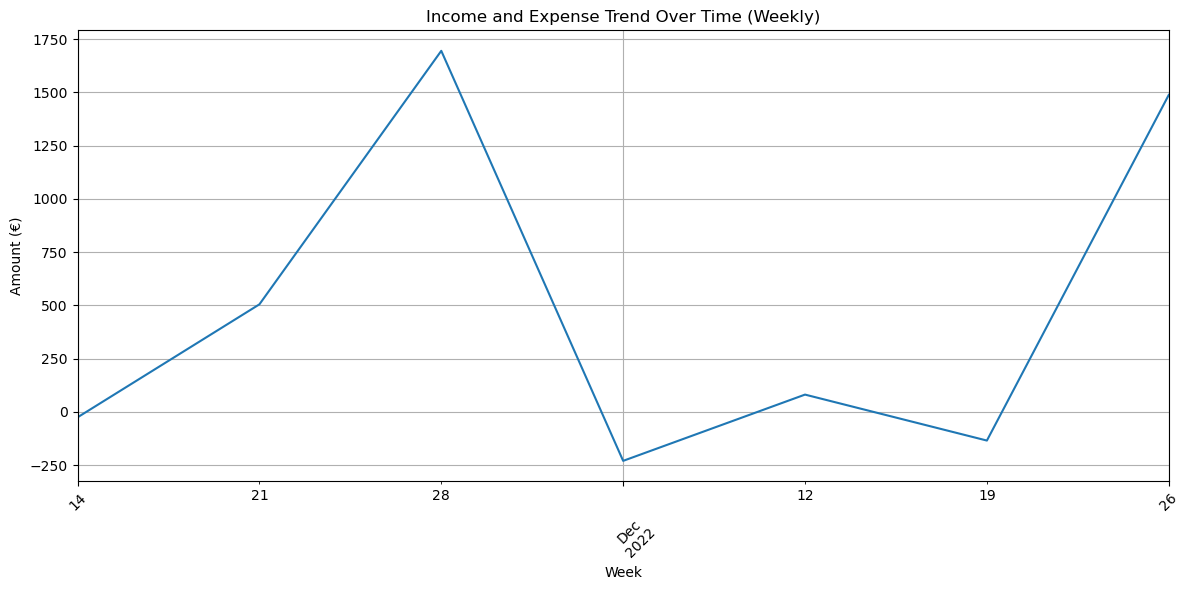

In [16]:
# Creates a time series analysis of income and expenses over time
income_expense_trend(df, plots_path)


## E. 4 Average Monthly Income/Expense
Calculate the average monthly income and expense to get an overall view of typical monthly financial activity.

In [17]:
# Calculates average monthly income and expenses.
text3 = average_monthly_stats(df)
print(text3)

Monthly income VS expanse: 
The average monthly income is €2744.49, and the average monthly expenses are €-1054.22. 
 



## E. 5 Recurring Transactions Detection
Identify recurring transactions such as regular payments (e.g., rent, subscriptions) or income (e.g., salary) based on similar amounts and descriptions.

In [18]:
# Identifies recurring transactions based on recipient and amount
recurring_summary = detect_recurring_transactions(df)
# Function which extracts the text info from the pandas df for the summary pdf later on
text4 = text_recurring_transactions(recurring_summary)
# Call the function and display the first few rows of the recurring transactions
recurring_summary.head()


,Zahlungsempfänger*in,Betrag (€),Count
0,Boulderhalle Leipzig Gm,-8.0,3


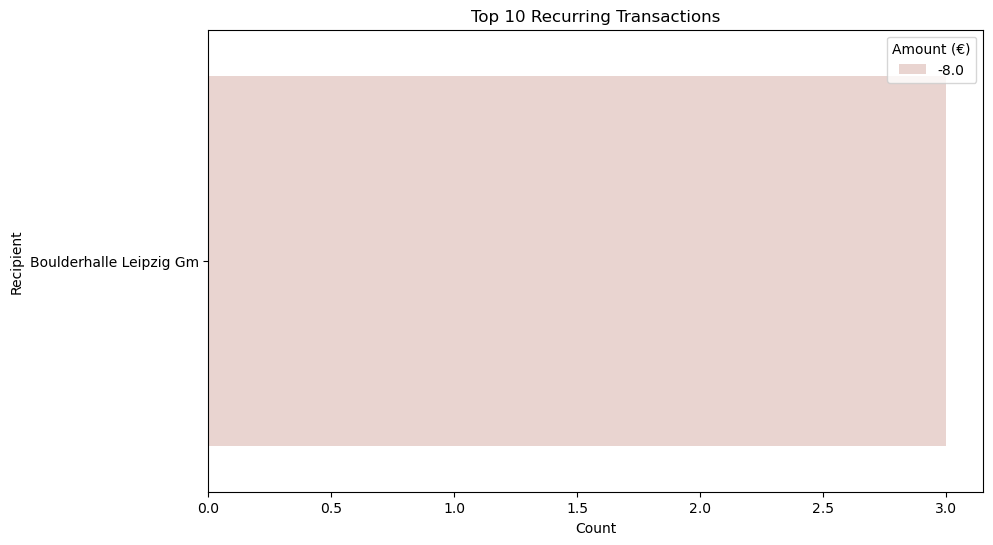

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_recurring_summary.png'

In [19]:
# Visualizes the top recurring transactions in a bar plot
plot_recurring_summary(recurring_summary, plots_path)

## E. 6 Monthly Expense to Income Ratio
Calculate the expense-to-income ratio to determine how much of your income is spent each month.

In [20]:
# Calculates the expense-to-income ratio per month
expense_income_ratio(df)



Expense to Income Ratio per Month:
month
2022-11    0.180770
2022-12    0.662393
Freq: M, Name: Betrag (€), dtype: float64


## E. 7 Expense Breakdown by Vendor/Recipient
Provide a breakdown of total expenses by Zahlungsempfänger*in to identify who you are spending the most money on.

In [21]:
# Provides a breakdown of expenses by recipient
expenses_by_recipient(df)


Expenses by Recipient:
Zahlungsempfänger*in
Tillmann Stralka                                -402.00
DB vertrieb GmbH                                -234.00
3273 Konsum Rosa Luxemb                         -189.34
DB Vertrieb GmbH                                -145.15
REWE Christopher S                              -100.12
Transact,Eisenbahnst53                          -100.00
Anja Porst                                       -96.88
AMAZON PAYMENTS EUROPE S.C.A.                    -81.92
SUMUP .LISBETHS ERBEN                            -79.10
Michaela Adamy                                   -61.00
3237 Konsum Eisenbahnst                          -52.49
HEGEL-APOTHEKE                                   -50.39
PAYPAL .9A LTD                                   -45.50
PAYPAL .CHRISTIAN.BUET                           -42.00
PAYPAL .DBVERTRIEBG                              -39.65
PAYPAL .ZUCKERJAGDW                              -35.00
Boulderhalle Leipzig Gm                          -34.50
ZET

## E. 8 Outlier Detection
Identify unusually large transactions by detecting outliers (e.g., large expenses that are significantly different from the average).

In [22]:
# Identifies unusual transactions using standard deviation
detect_outliers(df)


Outliers:
   Buchungsdatum  Betrag (€) Verwendungszweck
3     2022-12-29     1643.75    BEZUEGE 12.22
45    2022-11-29     2196.23    BEZUEGE 11.22


## E. 9 Savings Percentage
Calculate the percentage of income saved each month.

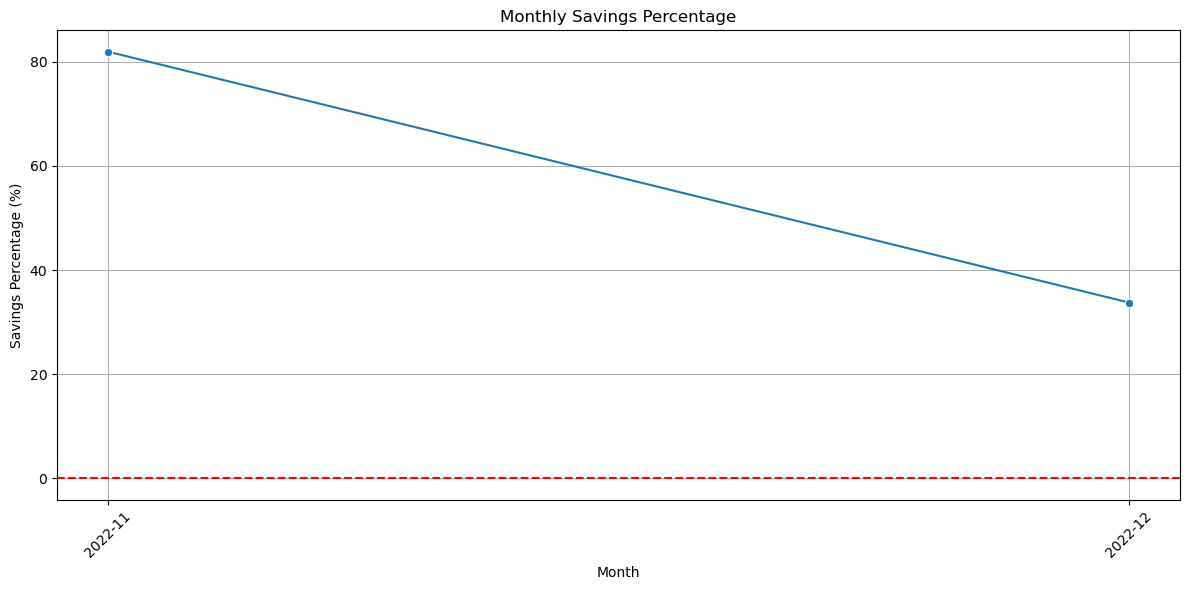

'/Users/tillo/Repositoriums/FinanceGrouper/plots/savings_percentage.png'

In [23]:
# Calculates and visualizes monthly savings percentage
savings_percentage(df, plots_path)

## E. 10 Cash Flow Stability
Calculate cash flow volatility to measure the consistency of your monthly income and expenses.

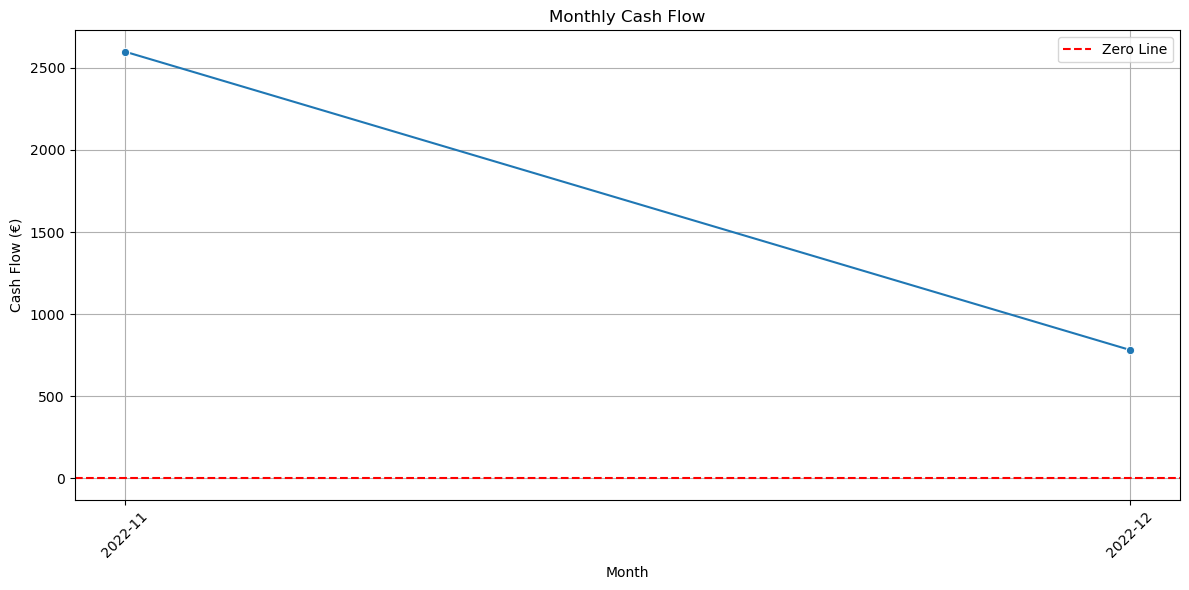

'/Users/tillo/Repositoriums/FinanceGrouper/plots/cash_flow_volatility.png'

In [24]:
# Calculates and visualizes cash flow stability over time
cash_flow_volatility(df, plots_path)

## E. 11 Income Sources Breakdown
Break down the sources of income (e.g., salary, refunds) by Zahlungspflichtige*r and analyze which contribute the most.

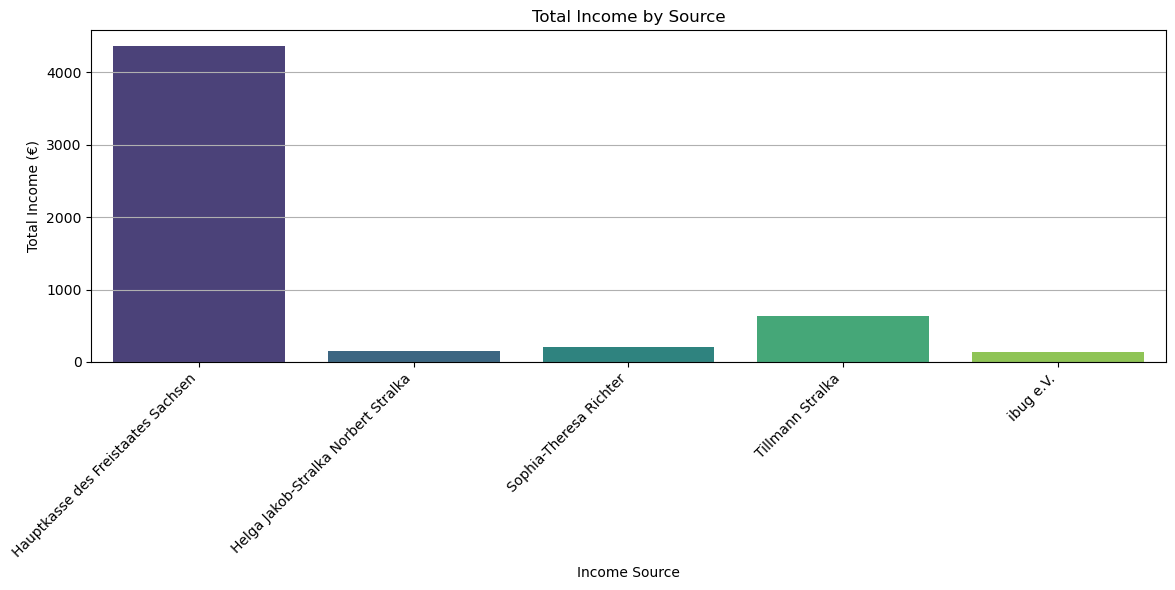

'/Users/tillo/Repositoriums/FinanceGrouper/plots/income_by_source.png'

In [25]:
# Analyzes and visualizes income sources with bar plots
income_by_source(df, plots_path)

## E. 12 Income VS. Expenses

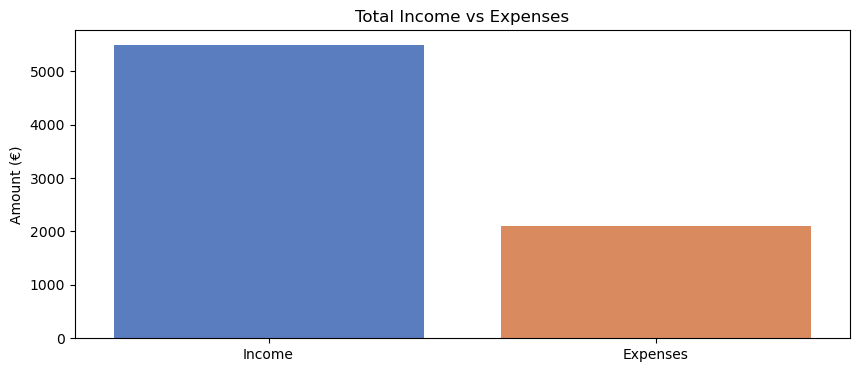

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_total_income_expenses.png'

In [26]:

plot_total_income_expenses(df, plots_path)

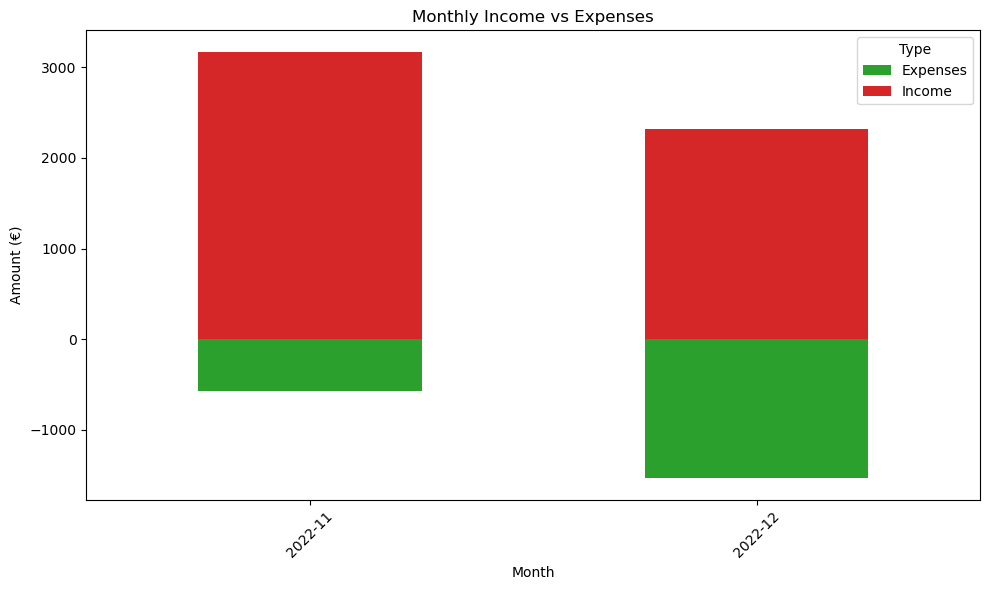

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_income_vs_expenses.png'

In [27]:

plot_monthly_income_vs_expenses(df, plots_path)

## E. 13 Savings and expanses distribution

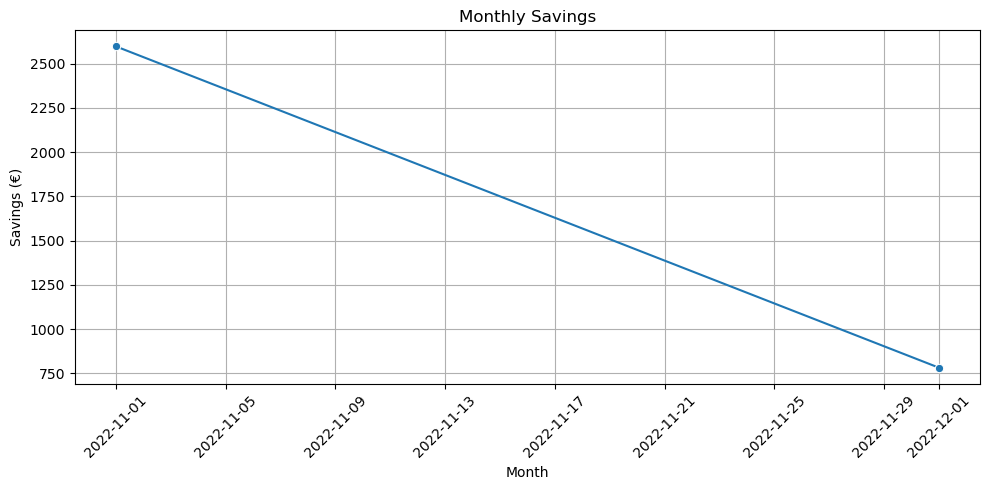

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_monthly_savings.png'

In [28]:


# Example execution
# Assuming 'df' is your DataFrame containing financial transactions
plot_monthly_savings(df, plots_path)

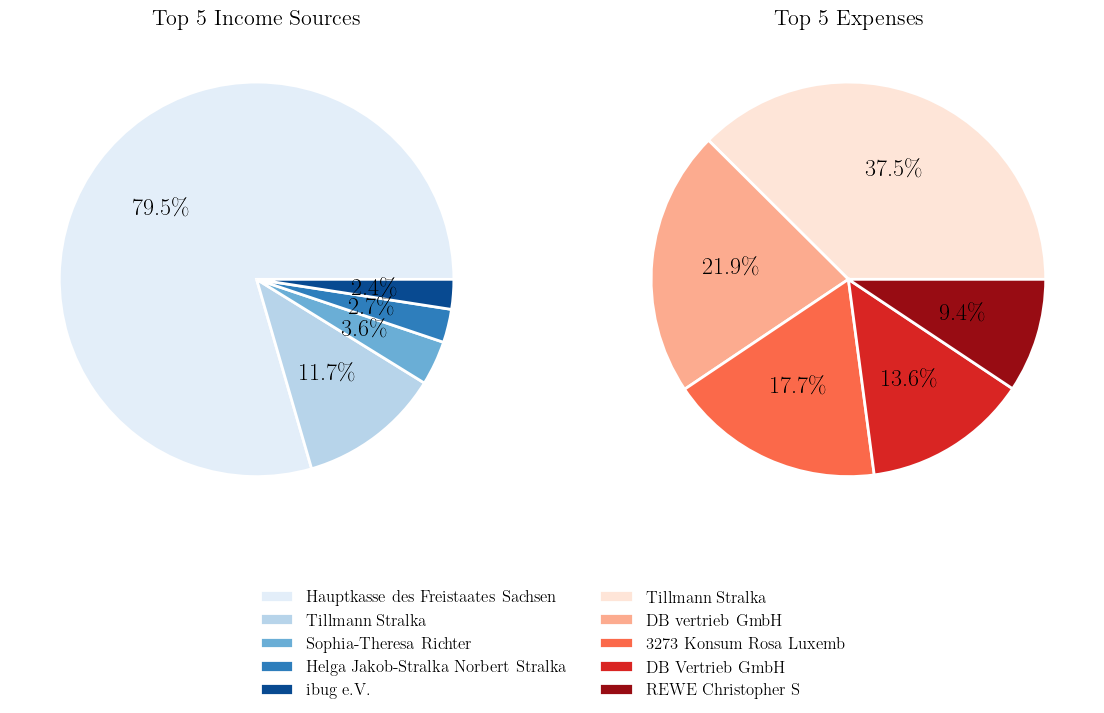

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_largest_expenses_income.png'

In [77]:
# Plot the larges income and expanses 
plot_largest_expenses_income(df, plots_path)



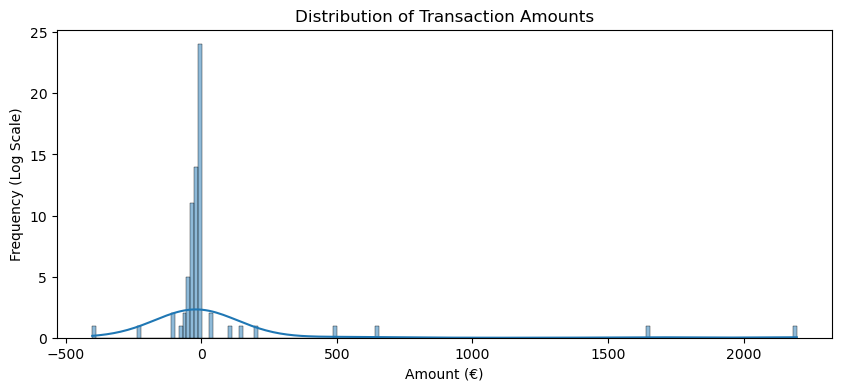

'/Users/tillo/Repositoriums/FinanceGrouper/plots/plot_transaction_distribution.png'

In [30]:


plot_transaction_distribution(df, plots_path)    

# E. 14 Category comparisson

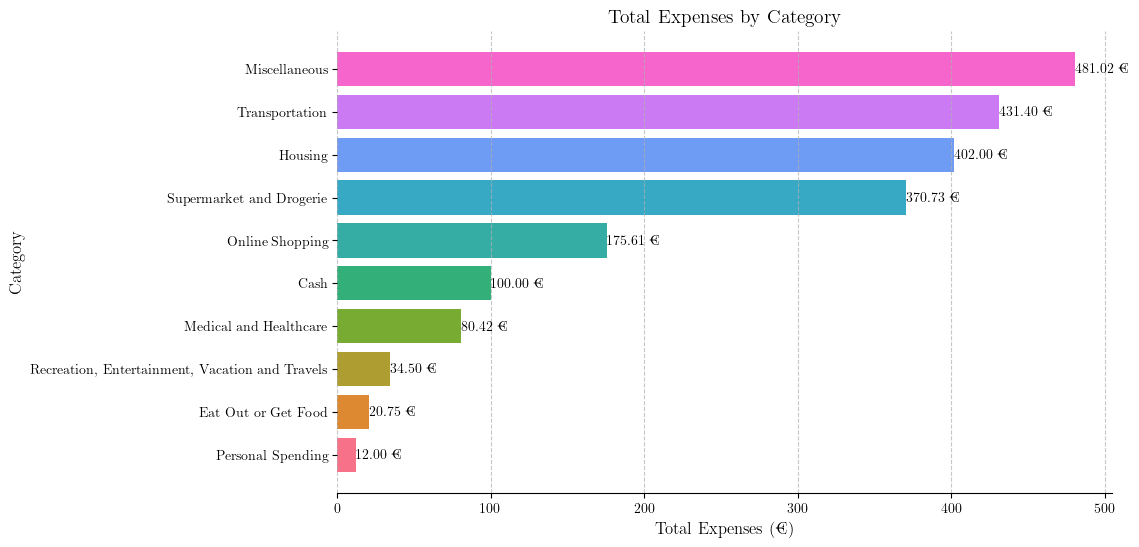

In [99]:
# Comparisson of expenses by category - absolut numbers 
saved_path = plot_expenses_barplot(df, plots_path)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

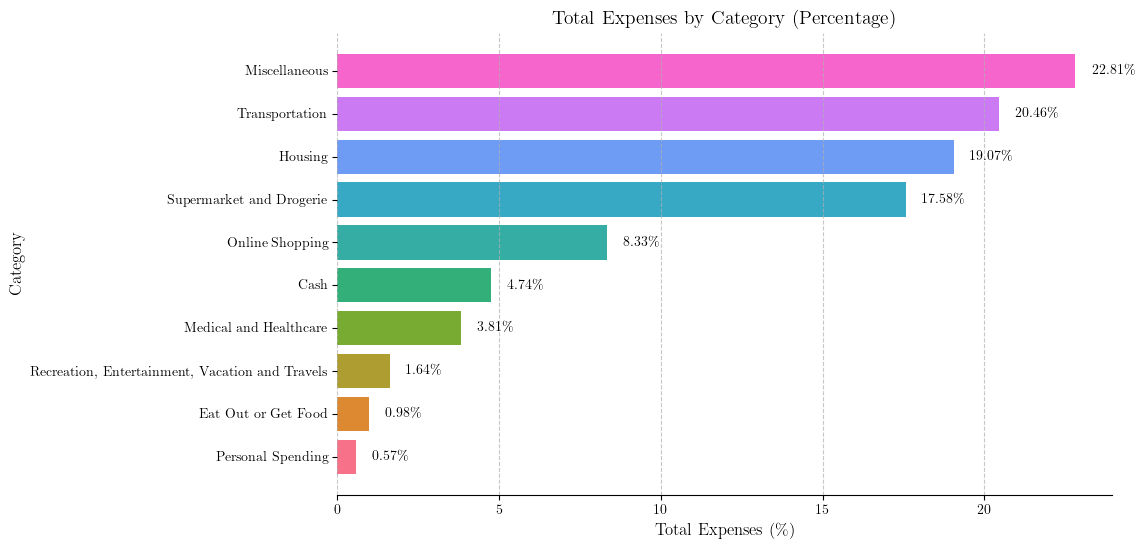

In [122]:
# Comparisson of expenses by category - relative
saved_path = plot_expenses_barplot_percent(df, plots_path)

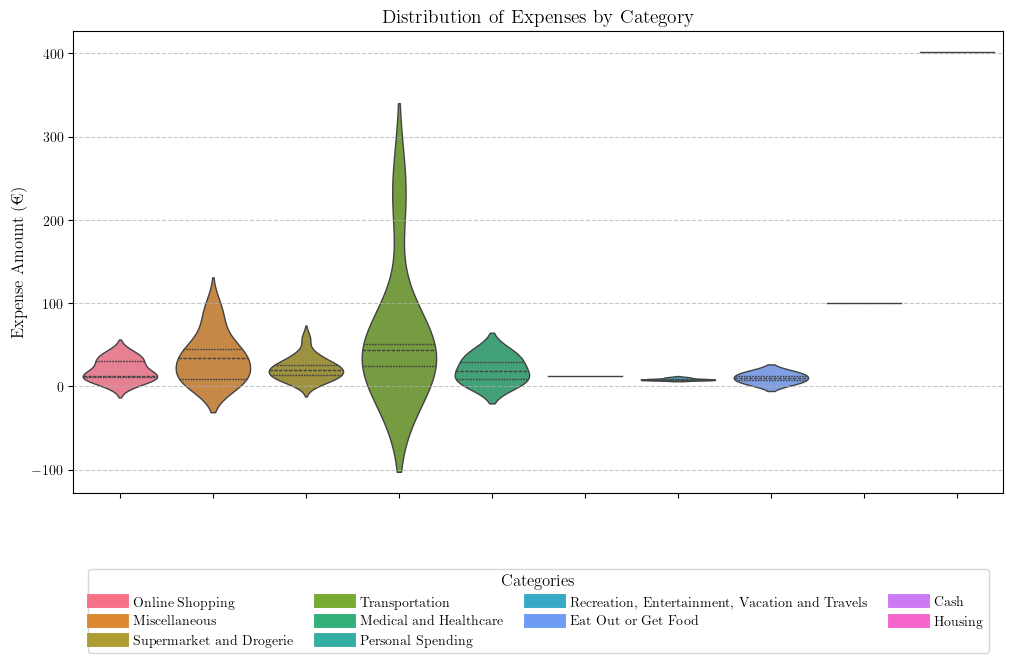

In [ ]:
# Distribution of expenses by category in a violin plot
saved_path = plot_expenses_violin(df, plots_path)


# F. Writing all the text output and images into a pdf for an overview sheet
- iterating through all functions seen above 
- iterating through all the plots which are saved in the plots folder 
- write it all down in a pdf and save it in reports 

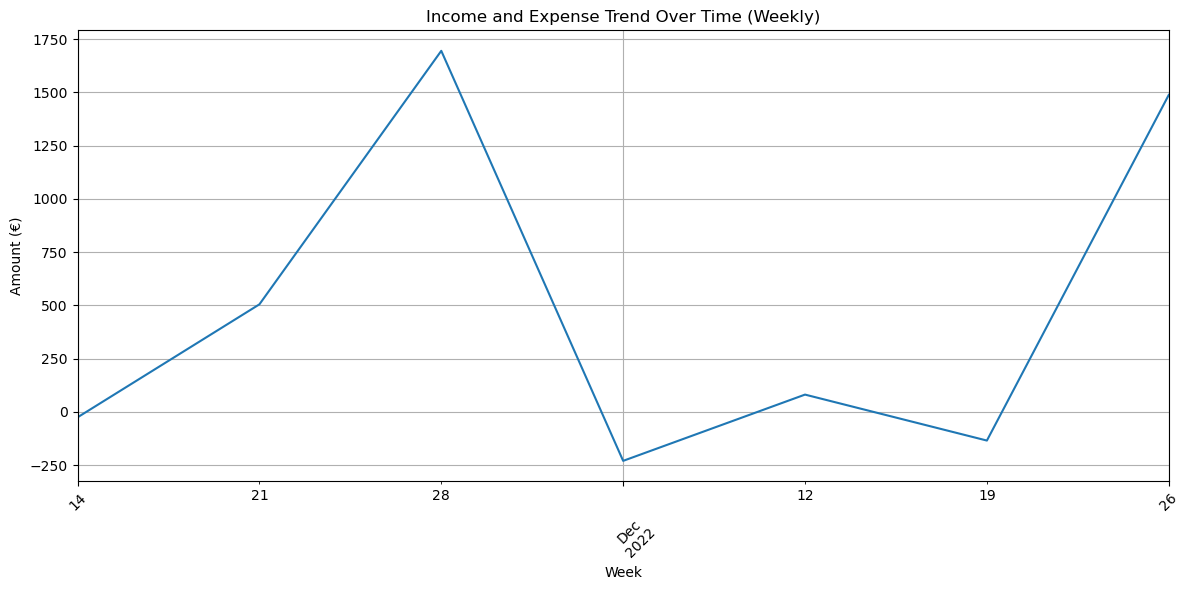

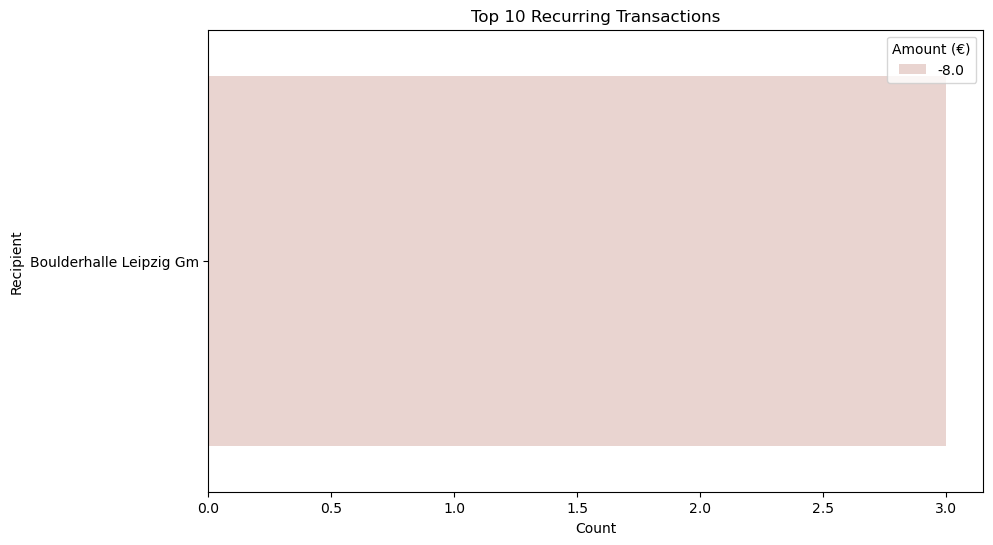

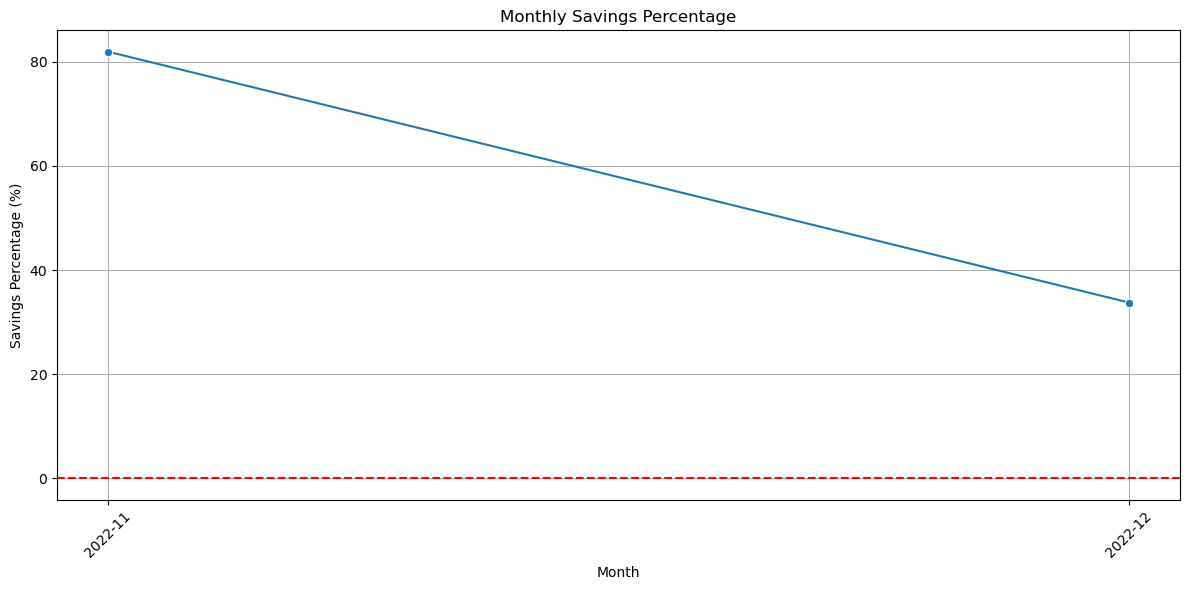

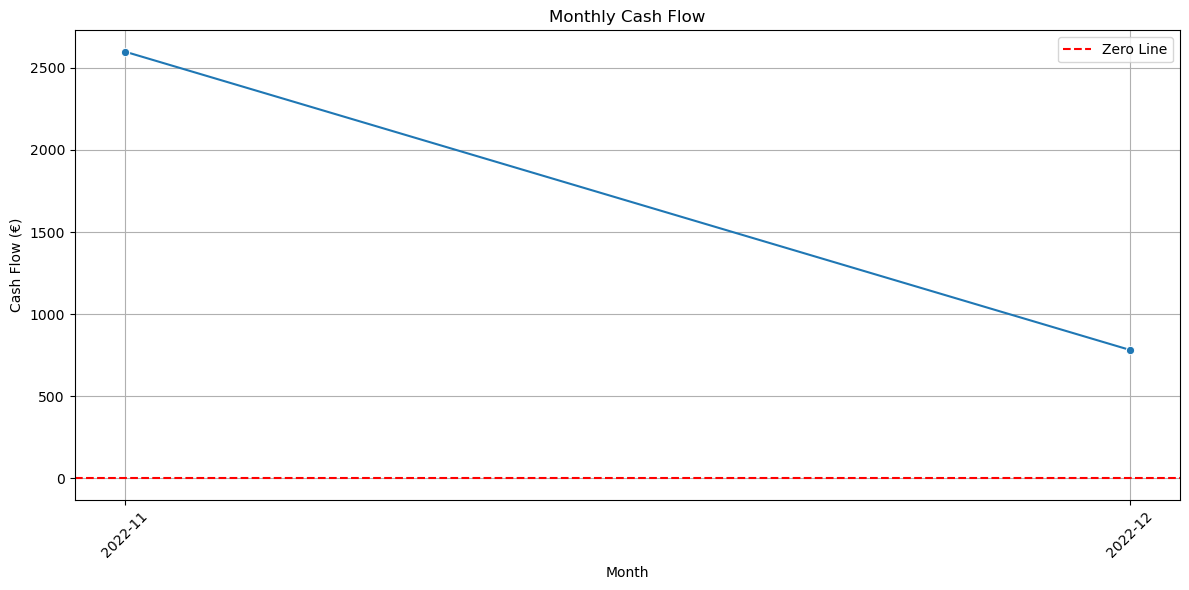

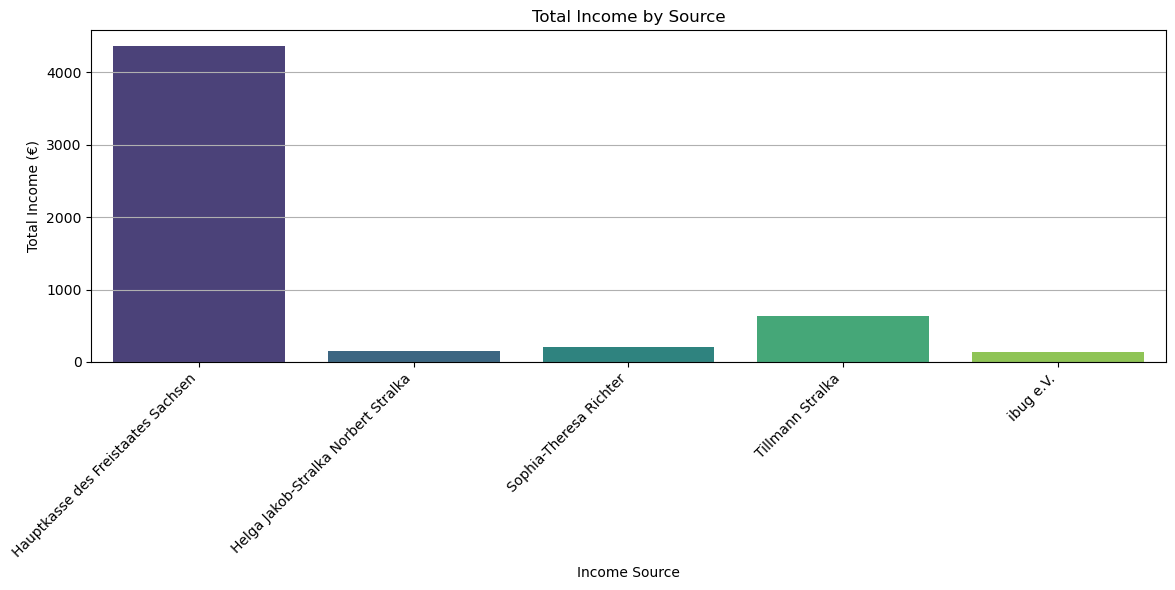

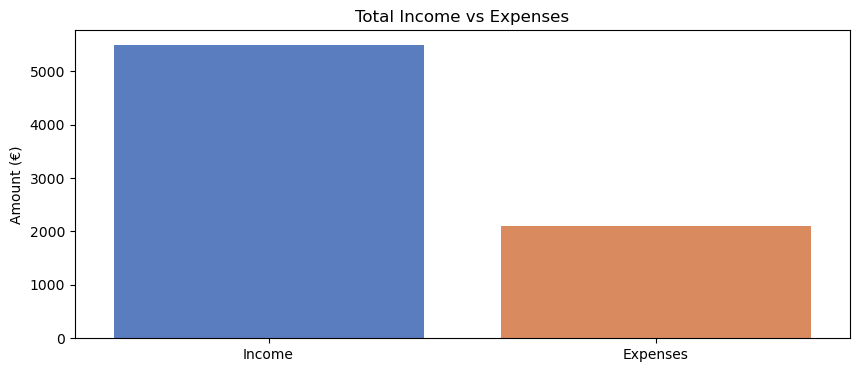

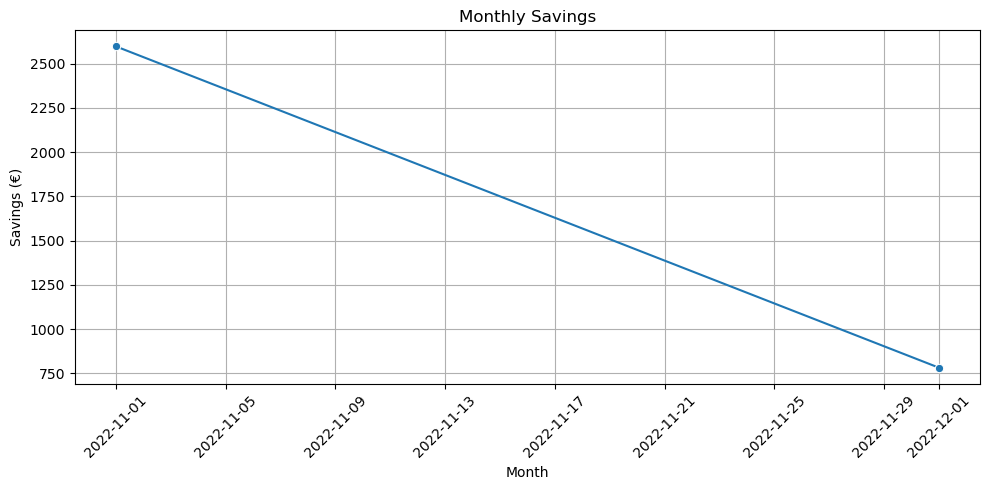

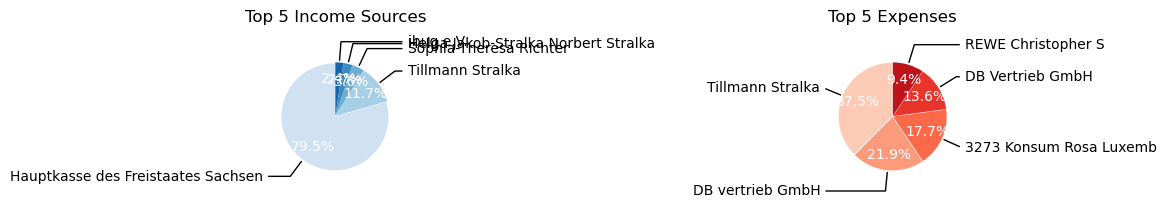

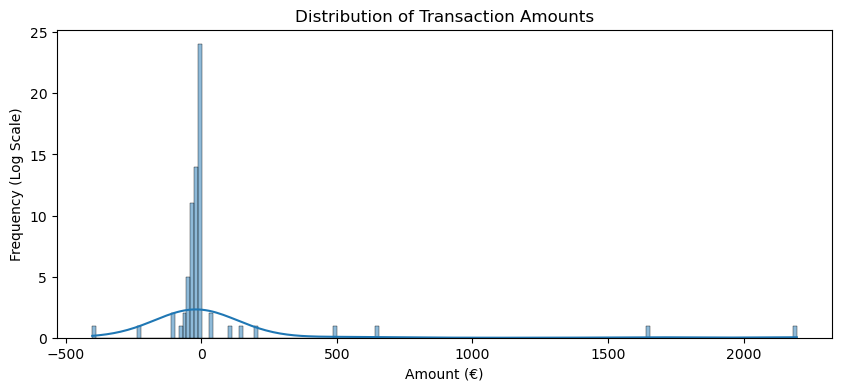

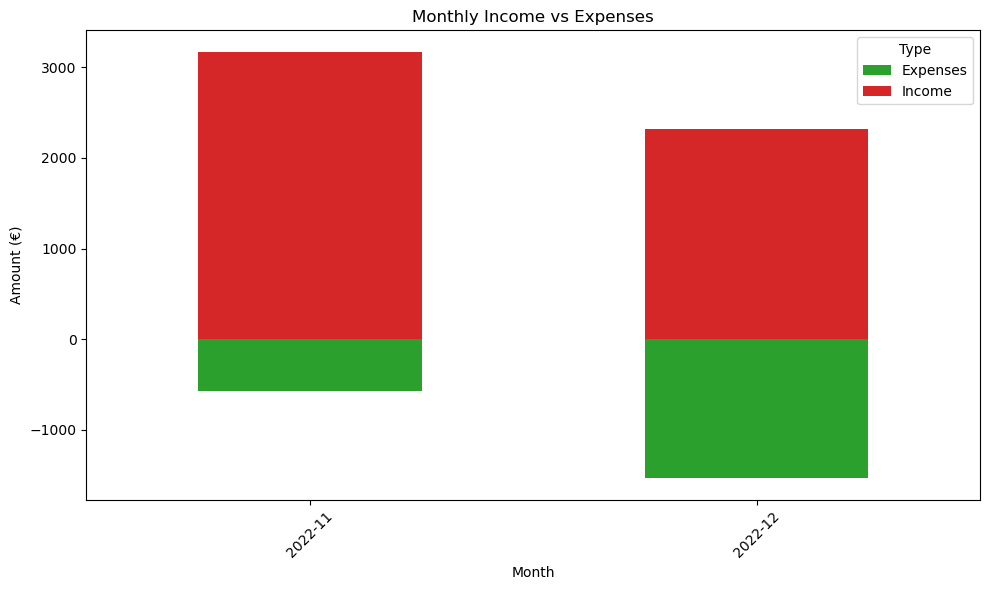

PDF saved to /Users/tillo/Repositoriums/FinanceGrouper/reports/financial_report.pdf


In [31]:

# Main programm for the pdf generation
# Separate functions will be called and the output (text and plots)
# Will be placed in the summary pdf 
if __name__ == "__main__":
    text_functions = [
        lambda: basic_analysis(df),
        lambda: average_monthly_stats(df),
        lambda: analyze_by_category(df),
        lambda: text_recurring_transactions(recurring_summary),
        #lambda: expense_income_ratio(df),
        #lambda: expenses_by_recipient(df),
        #lambda: detect_outliers(df)
    ]
    plot_functions = [
        lambda: income_expense_trend(df, plots_path),
        lambda: plot_recurring_summary(recurring_summary, plots_path),
        lambda: savings_percentage(df, plots_path),
        lambda: cash_flow_volatility(df, plots_path),
        lambda: income_by_source(df, plots_path),
        lambda: plot_total_income_expenses(df, plots_path),
        lambda: plot_monthly_savings(df, plots_path),
        lambda: plot_largest_expenses_income(df, plots_path),
        lambda: plot_transaction_distribution(df, plots_path),
        lambda: plot_monthly_income_vs_expenses(df, plots_path)
    ]

    output_pdf_path = os.path.join(report_path, "financial_report.pdf")
    save_to_pdf(text_functions, plot_functions, output_pdf_path)



# Next possible steps: 
+ Man könnte noch alle adressen rausnehmen 
+ Relableing 
+ Time Series analysis of income with prediction
+ Execute this with a dummy file into the data bevore publishing 
https://www.mockaroo.com/
+ Deployment of already existing machine learning models for word categorizing: German Bert 

# Old ? categorize the income and expanses 

In [32]:
import pandas as pd

# Annahme: df enthält eine 'Category' Spalte, die die Kategorien angibt, eine 'Amount' Spalte für den Betrag,
# und eine 'Type' Spalte, die entweder 'Income' oder 'Expenses' enthält.

# Berechne die Gesamtbeträge für Einnahmen und Ausgaben
total_incomes = df[df['Type'] == 'Income']['Amount'].sum()
total_expenses = df[df['Type'] == 'Expenses']['Amount'].sum()

# Berechne die Anzahl der Transaktionen pro Kategorie (für Ein- und Ausgaben)
income_counts = df[df['Type'] == 'Income'].groupby('Category').size()
expense_counts = df[df['Type'] == 'Expenses'].groupby('Category').size()

# Berechne die Prozentsätze der Transaktionen pro Kategorie
income_percentages = (income_counts / income_counts.sum()) * 100
expense_percentages = (expense_counts / expense_counts.sum()) * 100

# Berechne die Prozentsätze der Kategorien im Verhältnis zu den Gesamtbeträgen
income_percentages_amount = (df[df['Type'] == 'Income'].groupby('Category')['Amount'].sum() / total_incomes) * 100
expense_percentages_amount = (df[df['Type'] == 'Expenses'].groupby('Category')['Amount'].sum() / total_expenses) * 100

# Erstelle eine Tabelle mit den Ergebnissen
result = pd.DataFrame({
    'Income Count Percentage': income_percentages,
    'Expense Count Percentage': expense_percentages,
    'Income Amount Percentage': income_percentages_amount,
    'Expense Amount Percentage': expense_percentages_amount
})

# Ausgabe der Tabelle
print(result.fillna(0))  # Ersetze NaN-Werte durch 0, falls eine Kategorie keine Einnahmen oder Ausgaben hat


KeyError: 'Amount'

## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [ ]:
categories = {
    "eat_out_or_get_food": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Backerei",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "alltag_laden": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "vollcorner",
    ],
    "spezial_laden": [
        "karstadt",
        "galeria",
        "kaufhof",
        "mueller",
        "migros",
        "coop",
        "dm fil",
        "go asia",
        "Drogerie",
        "SUCKFUELL",
        "butlers",
        "Suckfull",
        "Bio-Market",
        "conrad m",
    ],
    "online_handel":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
    ],
    "transport": [
        "FERNVERKEHR",
        "flixbus",
        "PAYPAL .DBVERTR",
    ],
    "ausflug": [
        "hamburg",
        "Hotel",
        "PAYPAL .booking",
        "prague",
        "praha",
        "Tubingen",
    ],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "freizeit": [
        "VOLKSBAD",
        "PAYPAL .SENNHEISER",
    ],
    "entertainment": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix"
    ],
    "crypto": [
        "bitflyer",
        "coinbase"
    ],
    "health": [
        "apotheke",
        "Krankenversicherung",
    ],
    "cash": [
        "bargeld",
        "automat",
        "cash"
    ],
    "dkb": [
        "DKB",
        "KREDITBANK",
    ],
    "miete": [],
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    pt = x[posting_text].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)) or any(map(lambda r: r.lower() in pt, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

Breakdown by category. (Ignored transactions below 10€).

In [ ]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


### Category analysis

In [102]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

NameError: name 'party' is not defined

In [ ]:
quick_category_analyse("investment",desc=cause)

In [ ]:
quick_category_analyse("dkb", desc=cause)

In [ ]:
quick_category_analyse("ausflug")

In [ ]:
quick_category_analyse("card_payment")

In [ ]:
quick_category_analyse("transport")